# Raft vs. Tag Simple Case

In [93]:
%matplotlib inline

import os
import sys 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.viz import draw_topology
from cloudscope.viz import plot_workload

matplotlib.style.use('ggplot')
sns.set_context('talk')
sns.set_style('whitegrid')

In [94]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures", "results")
RESULTS  = [
    os.path.join(FIXTURES, "raft-best-case.json"),
    os.path.join(FIXTURES, "tagging-best-case.json"),
    os.path.join(FIXTURES, "raft-ping-pong.json"),
    os.path.join(FIXTURES, "tagging-ping-pong.json"),
]

def get_results_data(paths=RESULTS):
    for path in paths:
        # Compute the name of the experiment
        name, _ = os.path.splitext(os.path.basename(path))
        name = " ".join(name.split('-')[1:])
    
        # Open and load the data
        with open(path, 'r') as f:
            yield Results.load(f), name 

# Load the data
results = list(get_results_data())

In [95]:
# Strings
READ_COST = "mean read latency (ms)"
WRITE_COST = "mean write latency (ms)"
VISIBILITY_COST = "mean visibility latency (ms)"
COMMIT_COST = "mean commit latency (ms)"
SESSION_DURATION = "mean session duration (ms)"
TAG_SIZE = "average tag size"
VISIBLE_WRITES = "visible writes"
COMMITTED_WRITES = "committed writes"
SESSIONS = "sessions"
COMPLETED_READS = "completed reads"
COMPLETED_WRITES = "completed writes"
READS = "reads"
WRITES = "writes"
MISSED_READS = "missed reads"
DROPPED_WRITES = "dropped writes"
VISIBILITY_RATIO = "visibility ratio"
REPLICA = "replica"
CLUSTER = "cluster"
EXPERIMENT = "experiment"


def create_dataframe():
    
    # Handlers for various rows: return a dictionary to add to data frame. 
    def default_handler(key, values):
        return {
            key: len(values) 
        }
    
    def handle_visibility_latency(key, values):
        return {
            VISIBILITY_COST: sum(v[2] - v[1] for v in values if v[2] - v[1] < 1000) / len(values), 
            VISIBLE_WRITES: len(set([v[1] for v in values]))
        }
    
    def handle_commit_latency(key, values):
        return {
            COMMIT_COST: sum(v[2] - v[1] for v in values if v[2] - v[1] < 5000) / len(values),
            COMMITTED_WRITES: len(set([v[1] for v in values]))
        }

    def handle_session_length(key, values):
        return {
            SESSIONS: len(values), 
            SESSION_DURATION: sum(v[0] for v in values) / len(values),
        }

    def handle_read_latency(key, values):
        return {
            COMPLETED_READS: len(values), 
            READ_COST: sum(v[2] - v[1] for v in values) / len(values),
        }

    def handle_write_latency(key, values):
        return {
            COMPLETED_WRITES: len(values),
            WRITE_COST: sum(v[2] - v[1] for v in values) / len(values),
        }
    
    def handle_tag_size(key, values):
        return {
            TAG_SIZE: sum(v[1] for v in values) / len(values)
        }
    
    def rename_key(name, func=default_handler):
        def handle_rename(key, values):
            item = func(key, values)
            return {
                name: int(item[key])
            }
        return handle_rename
        

    # Handler map 
    handlers = {
        'visibility latency': handle_visibility_latency, 
        'commit latency': handle_commit_latency, 
        'session length': handle_session_length,
        'read latency': handle_read_latency,
        'write latency': handle_write_latency, 
        'tag size': handle_tag_size,
        'read': rename_key(READS),
        'write': rename_key(WRITES),
    }
    
    # Create a table with each replica id
    table = []
    
    for result, traces in results:
        rtype    = result.title.split()[0].lower()
        replicas = defaultdict(lambda: defaultdict(list)) 
        topology = result.topology
        config   = result.settings
        series   = result.results

        # Extract per-replica ID values from all results series 
        for key, values in series.iteritems():
            for value in values:
                # Some quick checks 
                assert len(value) > 1 
                assert value[0].startswith('r')

                # Append the series to the specific replica 
                replicas[value[0]][key].append(value[1:])

        # Append per-replica information to the table. 
        for replica, series in replicas.iteritems():
            row = {REPLICA: replica, CLUSTER: rtype, EXPERIMENT: traces} 

            # Perform per-replica aggreations for each result set 
            for serie, values in series.iteritems():
                handler = handlers.get(serie, default_handler)
                row.update(handler(serie, values))

            # Add in topology information 

    
            table.append(row)
    
    # Create the data frame and compute aggregate dependency items 
    df = pd.DataFrame(sorted(table, key=itemgetter(REPLICA)))
    df[MISSED_READS] = df[READS] - df[COMPLETED_READS]
    df[DROPPED_WRITES] = df[WRITES] - df[COMMITTED_WRITES]
    df[VISIBILITY_RATIO] = df[VISIBLE_WRITES] / df[WRITES]
    
    return df.fillna(0)

data = create_dataframe()

In [96]:
# Create Message Traffic Data Frame 
columns = ['replica', 'timestamp', 'type', 'latency']

def messages(results=results):
    for result, traces in results:
        rtype = result.title.split()[0].lower()
        for key in ('sent', 'recv'):
            for message in result.results[key]:
                msg = dict(zip(columns, message))
                msg['recv'] = 1 if key == 'recv' else 0
                msg['sent'] = 1 if key == 'sent' else 0
                msg['cluster'] = rtype 
                msg['experiment'] = traces
                yield msg

def count(nums):
    return sum(nums)

In [99]:
# Create the series to use in histograms 
def create_series(results=results):
    smap = {
        'visibility latency': VISIBILITY_COST,
        'commit latency': COMMIT_COST,
#         'session length': SESSION_DURATION,
        'read latency': READ_COST,
        'write latency': WRITE_COST,
    }
    
    series = defaultdict(list)
    
    for result, traces in results:
        rtype = result.title.split()[0].lower()
        
        for key, values in result.results.items():
            if key not in smap: continue 
            series[key].extend([
                {'cost': v[3] - v[2], 'cluster': rtype, 'experiment': traces} 
                for v in values
            ])

    return {
        smap[key]: pd.DataFrame(val)
        for key, val in series.items()
    }

## Topology

In [102]:
def show_topology(idx, results=results):
    topology = results[idx][0].topology 
    draw_topology(json_graph.node_link_graph(topology))
    
    print topology['meta']['title']
    print topology['meta']['variable']

Raft Quorum
15-45ms


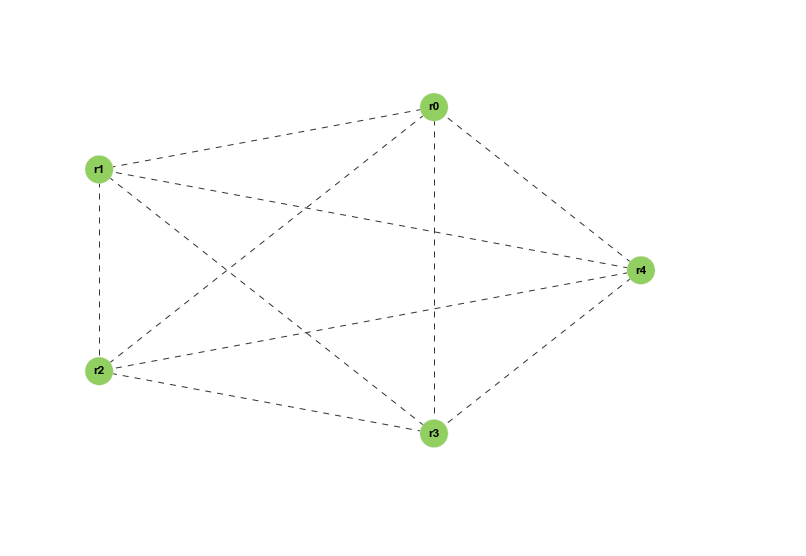

In [103]:
show_topology(0)

Tagging Quorum
15-45ms


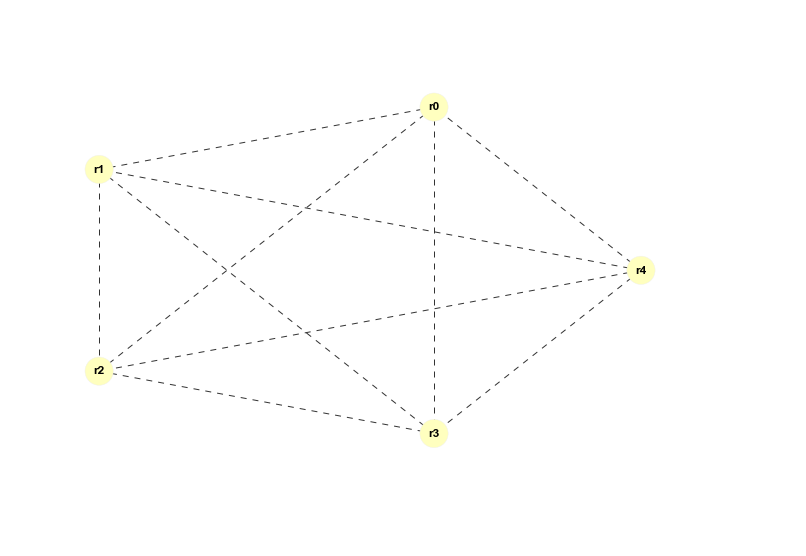

In [105]:
show_topology(1)

## Messages

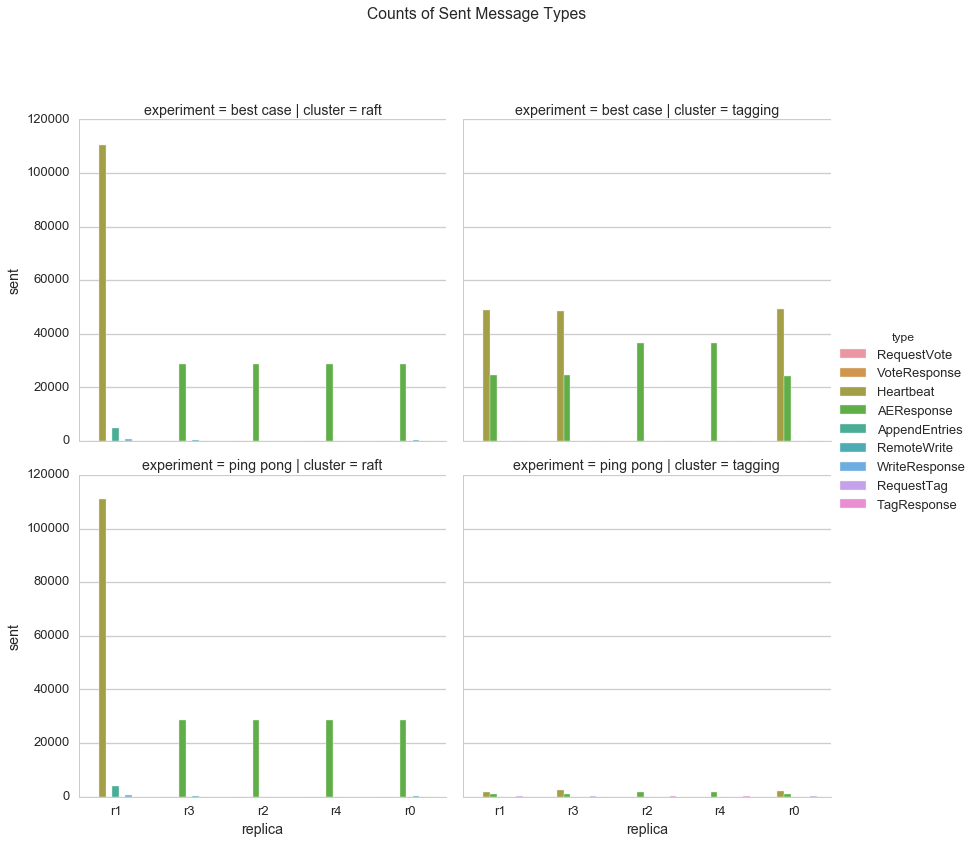

In [106]:
msgs = pd.DataFrame(messages())
g = sns.factorplot(
    y='sent', x='replica', hue='type', col='cluster', row='experiment',
    data=msgs, estimator=count, ci=None, kind='bar', size=6,
)

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Counts of Sent Message Types")

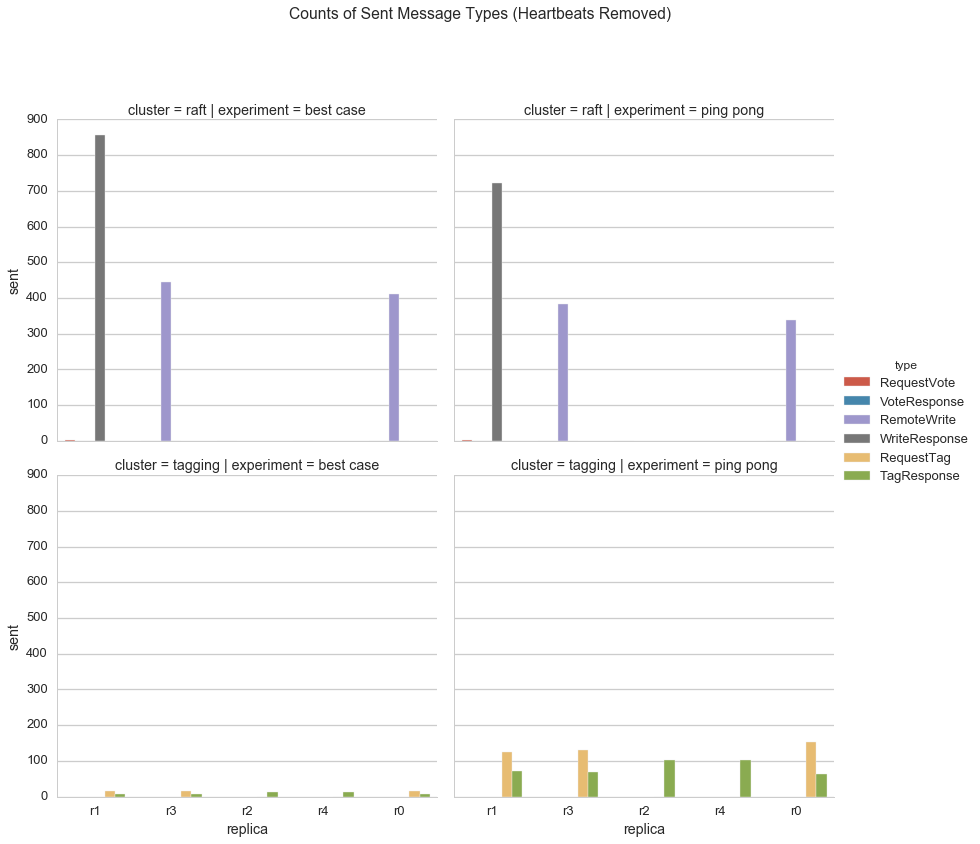

In [118]:
msgs = msgs[(msgs.type != 'Heartbeat') & (msgs.type != 'AEResponse') & (msgs.type != 'AppendEntries')]

g = sns.factorplot(
    y='sent', x='replica', hue='type', col='experiment', row='cluster',
    data=msgs, estimator=count, ci=None, kind='bar', size=6,
)

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Counts of Sent Message Types (Heartbeats Removed)")

## Accesses

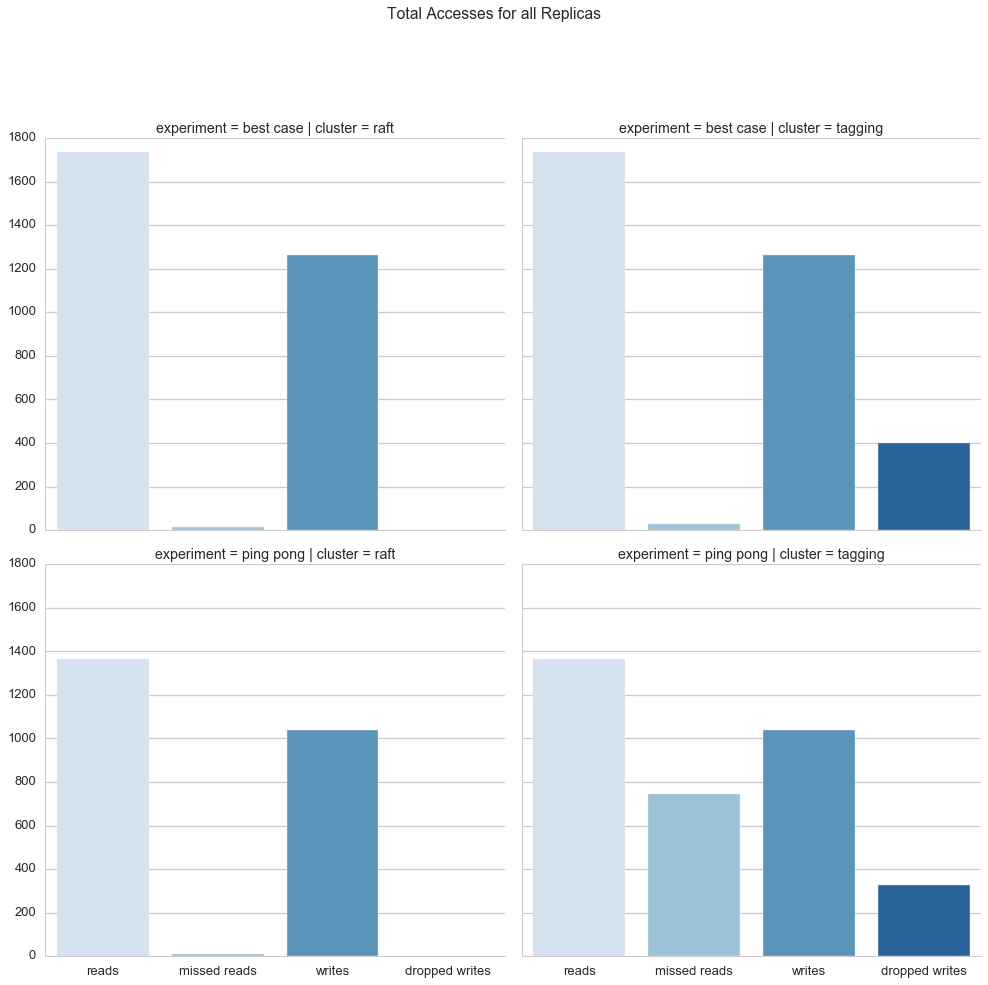

In [107]:
access = pd.DataFrame(data, columns=[CLUSTER, EXPERIMENT, READS, MISSED_READS, 
                                     WRITES, DROPPED_WRITES,])

g = sns.factorplot(
    col=CLUSTER, row=EXPERIMENT, data=access, kind='bar', 
    ci=None, size=7, palette='Blues', estimator=count
)

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Total Accesses for all Replicas")

## Cost 

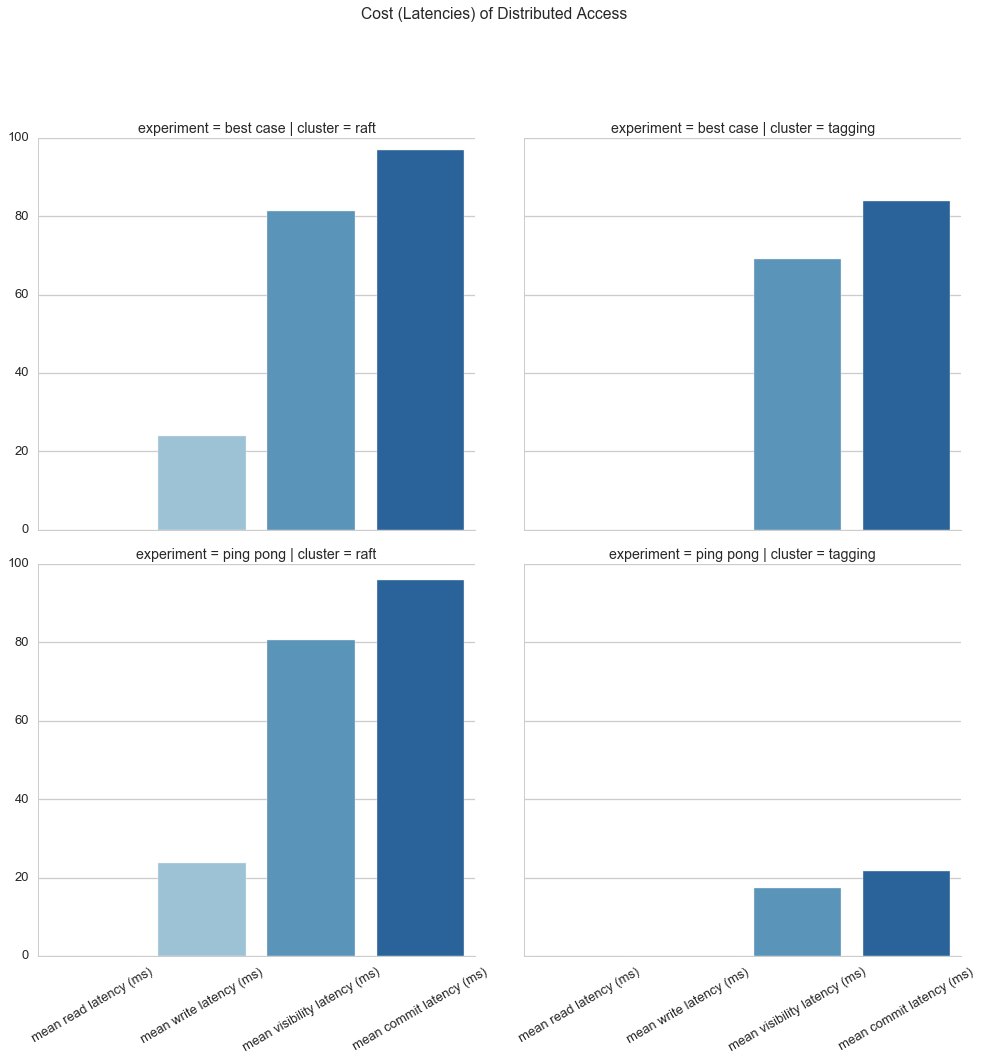

In [108]:
costs = pd.DataFrame(data, columns=[
        CLUSTER, EXPERIMENT, READ_COST, WRITE_COST, VISIBILITY_COST, COMMIT_COST,
    ])

g = sns.factorplot(
    col=CLUSTER, row=EXPERIMENT, data=costs, kind='bar', ci=None, size=7, palette='Blues'
)

g.set_xticklabels(rotation=30)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Cost (Latencies) of Distributed Access")

## Histograms 

In [109]:
series = create_series()

In [110]:
def show_histogram(name, density=False, outliers=None, series=series):
    if name not in series:
        print "Choose one of: {}".format(",".join(series.keys()))
        return None 
        
    df = series[name]
    if outliers:
        df = df[df.cost < outliers]
    
    g = sns.FacetGrid(df, col="cluster", row='experiment', size=7)
    if density:
        g.map(sns.distplot, "cost", hist=True, rug=True);
    
    else:
        g.map(plt.hist, "cost")
        
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(name)
    
    return g

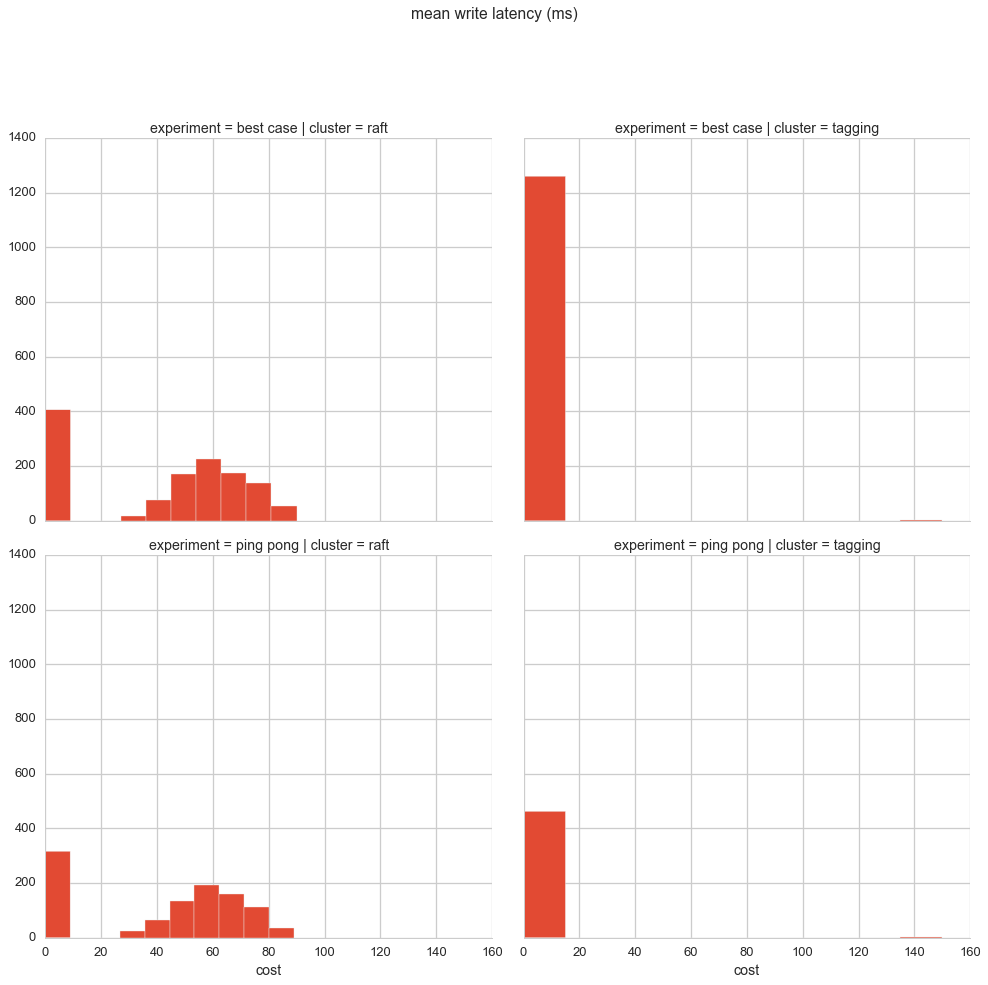

In [111]:
show_histogram(WRITE_COST)

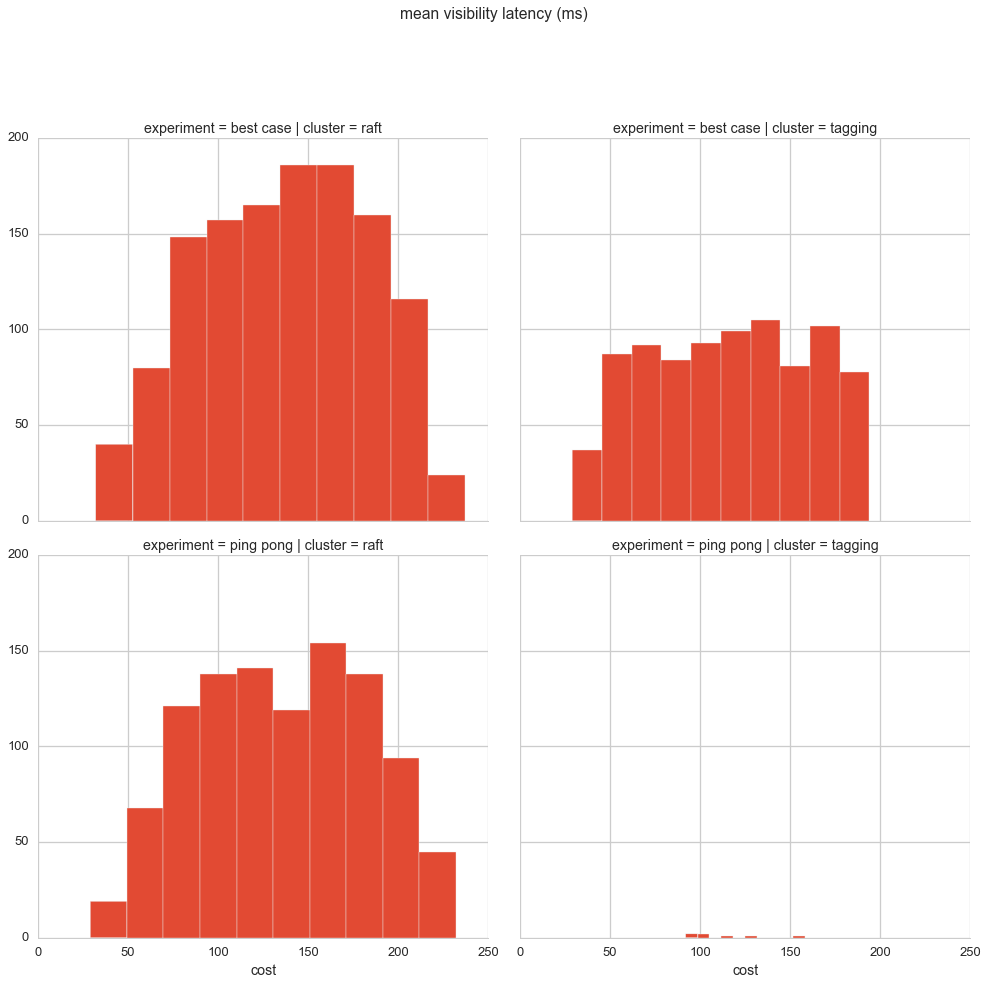

In [112]:
show_histogram(VISIBILITY_COST, outliers=1000)

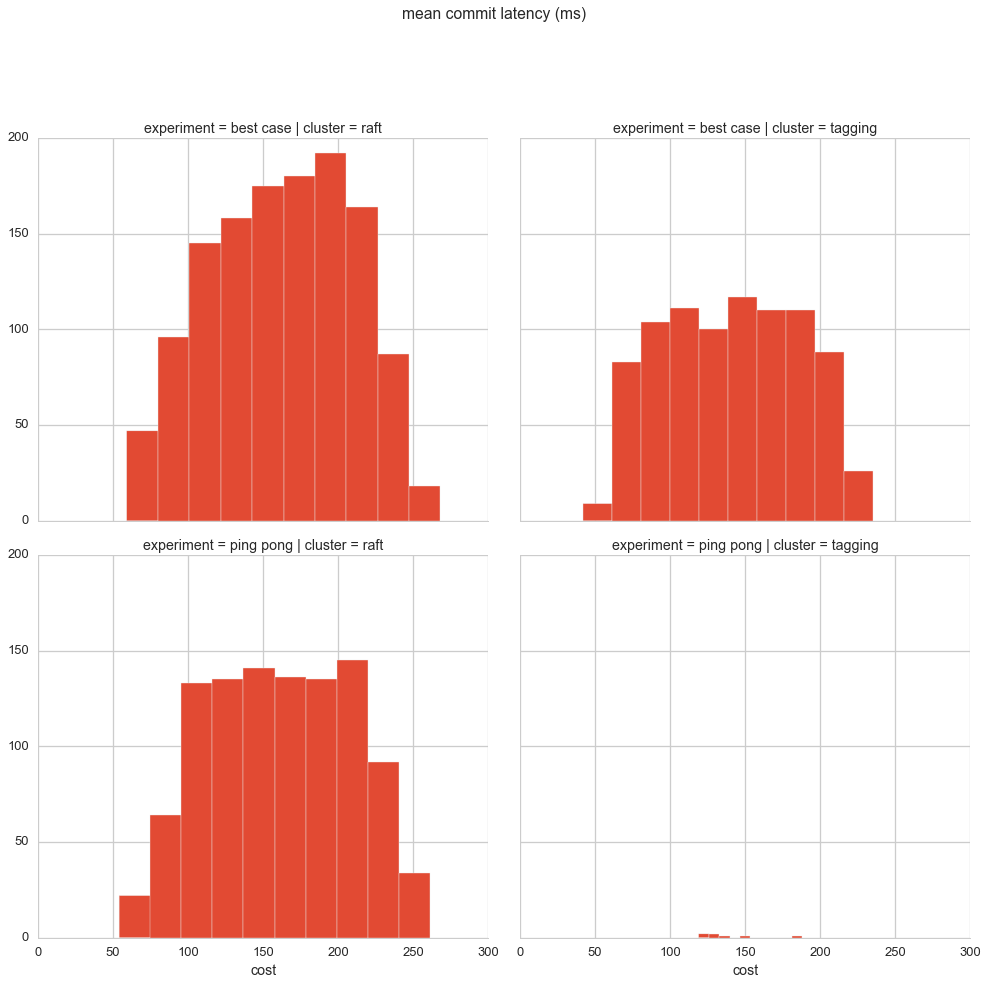

In [113]:
show_histogram(COMMIT_COST, outliers=5000)